In [1]:
library(ggplot2)
library(reshape2)
library(scater)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [3]:
allelic_F1 <- readRDS("/Users/z5345125/repos/ASPEN-GLM/data/aspensce_sexupdated_F1.rds")

In [4]:
# Subset columns (cells), not rows
keep_cols <- !is.na(allelic_F1$sex) & allelic_F1$sex != "Ambiguous" &
             !is.na(allelic_F1$condition_new) & allelic_F1$condition_new != "Ambiguous"

allelic_F1_filtered <- allelic_F1[, keep_cols]

allelic_F1_filtered

class: SingleCellExperiment 
dim: 15653 8522 
metadata(0):
assays(3): a1 a2 tot
rownames(15653): 0610005C13Rik 0610009E02Rik ... Zfp41 Zfp931
rowData names(0):
colnames(8522): Sample_1_AAACAGCCACCGGCTA Sample_1_AAACAGCCAGGATGGC ...
  Sample_8_repeat_TTTGTGTTCAAAGGCA Sample_8_repeat_TTTGTTGGTGTTGTAG
colData names(11): orig.ident sex ... counts_total_RNA
  genes_detected_RNA
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [5]:
allelic_F1_filtered

class: SingleCellExperiment 
dim: 15653 8522 
metadata(0):
assays(3): a1 a2 tot
rownames(15653): 0610005C13Rik 0610009E02Rik ... Zfp41 Zfp931
rowData names(0):
colnames(8522): Sample_1_AAACAGCCACCGGCTA Sample_1_AAACAGCCAGGATGGC ...
  Sample_8_repeat_TTTGTGTTCAAAGGCA Sample_8_repeat_TTTGTTGGTGTTGTAG
colData names(11): orig.ident sex ... counts_total_RNA
  genes_detected_RNA
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [6]:
saveRDS(allelic_F1_filtered, file = "/Users/z5345125/repos/ASPEN-GLM/data/aspensce_sexupdated_F1_filtered.rds")

### Analysis for different celltypes

In [35]:
## Load libraries

suppressPackageStartupMessages({
    if (requireNamespace("ASPEN", quietly = TRUE)) {
        library(ASPEN)
    } else {
        message("ASPEN not installed; sourcing all R/ functions …")
        rfiles <- list.files("../R", full.names = TRUE, pattern = "\\.R$")
        print(rfiles)
        invisible(lapply(rfiles, source))
    }
    library(ggplot2)
    library(ggpointdensity)
    library(gridExtra)
})


ASPEN not installed; sourcing all R/ functions …



[1] "../R/allelic_imbalance.R"    "../R/allelic_variation.R"   
[3] "../R/diagnostics.R"          "../R/diffASE.R"             
[5] "../R/estim_glmparams.R"      "../R/parameter_estimation.R"
[7] "../R/pipeline.R"             "../R/utils.R"               
[9] "../R/validation_helpers.R"  


In [41]:
list_group_dirs <- function(base_dir = "../results/celltype_wo_condition") {
  ct_dirs <- dir(base_dir, full.names = TRUE)
  if (!length(ct_dirs)) return(data.frame(path = character(), celltype = character(), condition = character(), stringsAsFactors = FALSE))
  ct_dirs <- ct_dirs[file.info(ct_dirs)$isdir]
  groups <- lapply(ct_dirs, function(ct_dir) {
    cond_dirs <- dir(ct_dir, full.names = TRUE)
    cond_dirs <- cond_dirs[file.info(cond_dirs)$isdir]
    if (!length(cond_dirs)) return(NULL)
    data.frame(
      path = cond_dirs,
      celltype = basename(ct_dir),
      condition = basename(cond_dirs),
      stringsAsFactors = FALSE
    )
  })
  groups <- Filter(Negate(is.null), groups)
  if (!length(groups)) return(data.frame(path = character(), celltype = character(), condition = character(), stringsAsFactors = FALSE))
  out <- do.call(rbind, groups)
  out$group_id <- paste(out$celltype, out$condition, sep = "__")
  rownames(out) <- out$group_id
  out
}

group_info <- list_group_dirs()
print(group_info)

group_map <- setNames(group_info$path, group_info$group_id)


                                                                             path
Cardiomyocyte__F1_Aged     ../results/celltype_wo_condition/Cardiomyocyte/F1_Aged
Cardiomyocyte__F1_Young   ../results/celltype_wo_condition/Cardiomyocyte/F1_Young
Coronary_EC__F1_Aged         ../results/celltype_wo_condition/Coronary_EC/F1_Aged
Coronary_EC__F1_Young       ../results/celltype_wo_condition/Coronary_EC/F1_Young
Endocardial_EC__F1_Aged   ../results/celltype_wo_condition/Endocardial_EC/F1_Aged
Endocardial_EC__F1_Young ../results/celltype_wo_condition/Endocardial_EC/F1_Young
Fibroblast__F1_Aged           ../results/celltype_wo_condition/Fibroblast/F1_Aged
Fibroblast__F1_Young         ../results/celltype_wo_condition/Fibroblast/F1_Young
M2__F1_Aged                           ../results/celltype_wo_condition/M2/F1_Aged
M2__F1_Young                         ../results/celltype_wo_condition/M2/F1_Young
MacFib__F1_Aged                   ../results/celltype_wo_condition/MacFib/F1_Aged
MacFib__F1_Young

In [44]:
group_mode <- "condition"  # options: "sex" or "global"
base_dir <- file.path("../results", "celltype_wo_condition")

summarise_group <- function(path, alpha = 0.05) {
  out <- list(
    n_rows_bb_mean = NA_integer_,
    n_rows_group_mean = NA_integer_,
    n_rows_group_var = NA_integer_,
    sig_FDR_bb_mean = NA_integer_,
    sig_FDR_group_mean = NA_integer_,
    sig_FDR_group_var = NA_integer_
  )
  bb_path <- file.path(path, "bb_mean_results.csv")
  if (file.exists(bb_path)) {
    df <- read.csv(bb_path, row.names = 1)
    out$n_rows_bb_mean <- nrow(df)
    if (nrow(df)) {
      p_adj <- p.adjust(df$pval_mean, method = "fdr")
      out$sig_FDR_bb_mean <- sum(is.finite(p_adj) & p_adj < alpha, na.rm = TRUE)
    }
  }
  gm_path <- file.path(path, "group_mean_sex_results.csv")
  if (file.exists(gm_path)) {
    df <- read.csv(gm_path, row.names = 1)
    out$n_rows_group_mean <- nrow(df)
    if (nrow(df)) {
      p_adj <- p.adjust(df$pval, method = "fdr")
      out$sig_FDR_group_mean <- sum(is.finite(p_adj) & p_adj < alpha, na.rm = TRUE)
    }
  }
  gv_path <- file.path(path, "group_var_sex_results.csv")
  if (file.exists(gv_path)) {
    df <- read.csv(gv_path, row.names = 1)
    out$n_rows_group_var <- nrow(df)
    if (nrow(df)) {
      p_adj <- p.adjust(df$pval_var, method = "fdr")
      out$sig_FDR_group_var <- sum(is.finite(p_adj) & p_adj < alpha, na.rm = TRUE)
    }
  }
  as.data.frame(out)
}

if (!nrow(group_info)) {
  message("No cell type/condition groups found under ", normalizePath(base_dir, mustWork = FALSE))
} else {
  summary_list <- vector("list", nrow(group_info))
  for (i in seq_len(nrow(group_info))) {
    grp_path <- group_info$path[i]
    grp_id   <- group_info$group_id[i]
    message("\nRendering panels for: ", grp_id, " (mode = ", group_mode, ")")
    try(render_ct_panels(grp_path, group_names = NULL, midpoint = 500, save_png = TRUE, mode = group_mode), silent = TRUE)
    tmp <- summarise_group(grp_path, alpha = 0.05)
    tmp$group_id  <- grp_id
    tmp$celltype  <- group_info$celltype[i]
    tmp$condition <- group_info$condition[i]
    summary_list[[i]] <- tmp
  }
  summary_df <- do.call(rbind, summary_list)
  out_csv <- file.path(base_dir, paste0("celltype_condition_summary_FDR0.05_", group_mode, ".csv"))
  write.csv(summary_df, out_csv, row.names = FALSE)
  message("Saved: ", out_csv)
  print(summary_df)
}



Rendering panels for: Cardiomyocyte__F1_Aged (mode = condition)


Rendering panels for: Cardiomyocyte__F1_Young (mode = condition)


Rendering panels for: Coronary_EC__F1_Aged (mode = condition)


Rendering panels for: Coronary_EC__F1_Young (mode = condition)


Rendering panels for: Endocardial_EC__F1_Aged (mode = condition)


Rendering panels for: Endocardial_EC__F1_Young (mode = condition)


Rendering panels for: Fibroblast__F1_Aged (mode = condition)


Rendering panels for: Fibroblast__F1_Young (mode = condition)


Rendering panels for: M2__F1_Aged (mode = condition)


Rendering panels for: M2__F1_Young (mode = condition)


Rendering panels for: MacFib__F1_Aged (mode = condition)


Rendering panels for: MacFib__F1_Young (mode = condition)


Rendering panels for: Mesothelial__F1_Aged (mode = condition)


Rendering panels for: Mesothelial__F1_Young (mode = condition)


Rendering panels for: Myeloid__F1_Aged (mode = condition)


Rendering panels for: Myeloid__F1_Young (mode = conditio

   n_rows_bb_mean n_rows_group_mean n_rows_group_var sig_FDR_bb_mean
1            6723              6723             6723            2175
2            6415              6415             6415            2025
3            1986              1986             1986             100
4            1793              1793             1793              81
5            2842              2842             2842              92
6            2119              2119             2119              82
7            4468              4468             4468             383
8            3308              3308             3308             240
9            1227              1227             1227              77
10           1152              1152             1152              56
11           2730              2730             2730              93
12           1643              1643             1643              54
13           1176              1176             1176              56
14           1383              138

## Show the GLM quality results for different cell types

In [45]:
suppressPackageStartupMessages({
ok_aspen <- requireNamespace("ASPEN", quietly = TRUE)
if (ok_aspen) {
library(ASPEN)
} else {
message("ASPEN not installed; sourcing R/ …")
rfiles <- list.files("../R", full.names = TRUE, pattern = "*.R$")
invisible(lapply(rfiles, source))
}
library(SingleCellExperiment)
library(Matrix)
})

# Paths
sce_path <- "../data/aspensce_sexupdated_F1_filtered.rds" # change if needed
base_dir <- "../results/celltype_wo_condition"

# Helpers
.pick_ct_col <- function(meta) {
for (nm in c("celltype_new","celltype","celltype_old")) if (!is.null(meta[[nm]])) return(nm)
stop("No celltype column found (celltype_new/celltype/celltype_old)")
}
.parse_thresholds <- function(log_path, default_counts = 5L, default_cells = 50L) {
min_counts <- default_counts; min_cells <- default_cells
if (file.exists(log_path)) {
ln <- readLines(log_path, warn = FALSE)
m1 <- sub(".min_counts=([0-9]+).", "\1", ln[grepl("min_counts=", ln)])
m2 <- sub(".min_cells=([0-9]+).", "\1", ln[grepl("min_cells=", ln)])
if (length(m1) > 0 && grepl("^[0-9]+$", m1[1])) min_counts <- as.integer(m1[1])
if (length(m2) > 0 && grepl("^[0-9]+$", m2[1])) min_cells <- as.integer(m2[1])
}
list(min_counts = min_counts, min_cells = min_cells)
}

fit_one_gene <- function(y, n, design) {
df <- as.data.frame(design); df$resp <- y / n
fit <- tryCatch(glm(resp ~ ., family = quasibinomial(), weights = n, data = df,
control = glm.control(maxit = 100)),
error = function(e) NULL)
fit
}

# Extract per-gene coefficients for terms of interest (sex*)
coef_rows_for_terms <- function(fit, terms_regex = c("^sex")) {
if (is.null(fit)) return(NULL)
cf <- tryCatch(summary(fit)$coefficients, error = function(e) NULL)
if (is.null(cf)) return(NULL)
rn <- rownames(cf)
out <- list()
for (rgx in terms_regex) {
idx <- grep(rgx, rn)
if (length(idx) == 0) next
for (j in idx) {
out[[length(out)+1]] <- data.frame(
term = rn[j],
estimate = cf[j,1],
se = cf[j,2],
z = cf[j,3],
p = cf[j,4],
stringsAsFactors = FALSE
)
}
}
if (length(out) == 0) return(NULL)
do.call(rbind, out)
}

analyze_group <- function(grp_path, sce, meta, ct_col, sex_all, cond_all) {
ct <- basename(dirname(grp_path))
cond_label <- basename(grp_path)
grp_id <- paste(ct, cond_label, sep = "__")

est_path <- file.path(grp_path, "estimates_global_shrunk.rds")
if (!file.exists(est_path)) { message("No estimates for ", grp_id); return(NULL) }
est <- readRDS(est_path)
genes <- rownames(est)

cells_ct <- which(as.character(meta[[ct_col]]) == ct & cond_all == cond_label & sex_all %in% c("F","M"))
if (length(cells_ct) < 5) { message("Too few cells for ", grp_id); return(NULL) }

a1s <- SummarizedExperiment::assay(sce, "a1")[, cells_ct, drop = FALSE]
tots <- SummarizedExperiment::assay(sce, "tot")[, cells_ct, drop = FALSE]
genes_in <- intersect(genes, rownames(tots))
a1 <- as.matrix(a1s[genes_in, , drop = FALSE]); mode(a1) <- "integer"
tot <- as.matrix(tots[genes_in, , drop = FALSE]); mode(tot) <- "integer"

# Build design: sex only
sex <- factor(sex_all[cells_ct], levels = c("F","M"))
design_df <- data.frame(sex = sex)
rownames(design_df) <- colnames(tot)
design <- model.matrix(~ sex, data = design_df)

# thresholds from filter_log
thr <- .parse_thresholds(file.path(grp_path, "filter_log.txt"), default_counts = 5L, default_cells = 50L)
min_counts <- thr$min_counts; min_cells <- thr$min_cells

coef_list <- list()
fit_list <- list()
for (g in rownames(a1)) {
y <- as.numeric(a1[g, ]); n <- as.numeric(tot[g, ])
keep <- is.finite(y) & is.finite(n) & (n >= min_counts)
if (sum(keep) < min_cells) next
fit <- fit_one_gene(y[keep], n[keep], design[keep, , drop = FALSE])
if (is.null(fit)) next
fit_list[[g]] <- data.frame(
  gene = g,
  converged = isTRUE(fit$converged),
  iter = fit$iter,
  null_dev = fit$null.deviance,
  deviance = fit$deviance,
  df_null = fit$df.null,
  df_resid = fit$df.residual,
  r2_mcfadden = ifelse(is.finite(fit$null.deviance) && fit$null.deviance > 0, 1 - (fit$deviance / fit$null.deviance), NA_real_),
  stringsAsFactors = FALSE
)
cf <- coef_rows_for_terms(fit, terms_regex = c("^sex"))
if (!is.null(cf)) {
  cf$gene <- g
  coef_list[[g]] <- cf
}
}

coef_df <- if (length(coef_list) > 0) do.call(rbind, coef_list) else data.frame()
fit_df  <- if (length(fit_list) > 0) do.call(rbind, fit_list) else data.frame()
list(group_id = grp_id, coef_df = coef_df, fit_df = fit_df, path = grp_path)
}

# Run across groups and write outputs
sce <- readRDS(sce_path)
meta <- as.data.frame(colData(sce))
ct_col <- .pick_ct_col(meta)
sex_all <- as.character(meta$sex)
sex_all[sex_all %in% c("Female","F")] <- "F"
sex_all[sex_all %in% c("Male","M")] <- "M"
cond_all <- meta$condition_new
if (is.null(cond_all)) cond_all <- meta$condition_old
cond_all <- as.character(cond_all)
cond_all[is.na(cond_all) | cond_all == ""] <- "NA"

group_paths <- group_info$path
all_coef <- list(); all_fit <- list()
for (grp_path in group_paths) {
res <- analyze_group(grp_path, sce, meta, ct_col, sex_all, cond_all)
if (is.null(res)) next
if (nrow(res$coef_df) > 0) {
write.csv(res$coef_df, file.path(res$path, "glm_coef_by_gene.csv"), row.names = FALSE)
message("Saved coef table: ", file.path(res$path, "glm_coef_by_gene.csv"))
}
if (nrow(res$fit_df) > 0) {
write.csv(res$fit_df, file.path(res$path, "glm_model_fit_by_gene.csv"), row.names = FALSE)
message("Saved model fit table: ", file.path(res$path, "glm_model_fit_by_gene.csv"))
}
all_coef[[res$group_id]] <- res$coef_df
all_fit[[res$group_id]]  <- res$fit_df
}

# Aggregate quick summaries (percent significant per term; median R2)
summ_rows <- list()
for (gid in names(all_coef)) {
cf <- all_coef[[gid]]
mf <- all_fit[[gid]]
if (nrow(cf) == 0 || nrow(mf) == 0) next
sex_rows <- cf[grepl("^sex", cf$term), , drop = FALSE]
summ_rows[[gid]] <- data.frame(
celltype = group_info$celltype[group_info$group_id == gid],
condition = group_info$condition[group_info$group_id == gid],
group_id = gid,
n_genes_fit = length(unique(mf$gene)),
median_r2_mcfadden = median(mf$r2_mcfadden, na.rm = TRUE),
sex_terms = paste(unique(sex_rows$term), collapse = ";"),
pct_sig_sex = mean(sex_rows$p < 0.05, na.rm = TRUE),
stringsAsFactors = FALSE
)
}
summ_out <- if (length(summ_rows) > 0) do.call(rbind, summ_rows) else data.frame()
print(summ_out)
if (nrow(summ_out) > 0) {
out_csv <- file.path(base_dir, "glm_coef_significance_summary_groups.csv")
write.csv(summ_out, out_csv, row.names = FALSE)
message("Saved: ", out_csv)
}


ASPEN not installed; sourcing R/ …

Saved coef table: ../results/celltype_wo_condition/Cardiomyocyte/F1_Aged/glm_coef_by_gene.csv

Saved model fit table: ../results/celltype_wo_condition/Cardiomyocyte/F1_Aged/glm_model_fit_by_gene.csv

Saved coef table: ../results/celltype_wo_condition/Cardiomyocyte/F1_Young/glm_coef_by_gene.csv

Saved model fit table: ../results/celltype_wo_condition/Cardiomyocyte/F1_Young/glm_model_fit_by_gene.csv

Saved coef table: ../results/celltype_wo_condition/Coronary_EC/F1_Aged/glm_coef_by_gene.csv

Saved model fit table: ../results/celltype_wo_condition/Coronary_EC/F1_Aged/glm_model_fit_by_gene.csv

Saved coef table: ../results/celltype_wo_condition/Coronary_EC/F1_Young/glm_coef_by_gene.csv

Saved model fit table: ../results/celltype_wo_condition/Coronary_EC/F1_Young/glm_model_fit_by_gene.csv

Saved coef table: ../results/celltype_wo_condition/Endocardial_EC/F1_Aged/glm_coef_by_gene.csv

Saved model fit table: ../results/celltype_wo_condition/Endocardial_EC/F

                               celltype condition                 group_id
Cardiomyocyte__F1_Aged    Cardiomyocyte   F1_Aged   Cardiomyocyte__F1_Aged
Cardiomyocyte__F1_Young   Cardiomyocyte  F1_Young  Cardiomyocyte__F1_Young
Coronary_EC__F1_Aged        Coronary_EC   F1_Aged     Coronary_EC__F1_Aged
Coronary_EC__F1_Young       Coronary_EC  F1_Young    Coronary_EC__F1_Young
Endocardial_EC__F1_Aged  Endocardial_EC   F1_Aged  Endocardial_EC__F1_Aged
Endocardial_EC__F1_Young Endocardial_EC  F1_Young Endocardial_EC__F1_Young
Fibroblast__F1_Aged          Fibroblast   F1_Aged      Fibroblast__F1_Aged
Fibroblast__F1_Young         Fibroblast  F1_Young     Fibroblast__F1_Young
M2__F1_Aged                          M2   F1_Aged              M2__F1_Aged
M2__F1_Young                         M2  F1_Young             M2__F1_Young
MacFib__F1_Aged                  MacFib   F1_Aged          MacFib__F1_Aged
MacFib__F1_Young                 MacFib  F1_Young         MacFib__F1_Young
Mesothelial__F1_Aged     

Saved: ../results/celltype_wo_condition/glm_coef_significance_summary_groups.csv



### Imbalance test (estimate the global mean first)

In [48]:
suppressPackageStartupMessages({
  if (requireNamespace("ASPEN", quietly = TRUE)) {
    library(ASPEN)
  } else {
    message("ASPEN not installed; sourcing ../R …")
    rfiles <- list.files("../R", full.names = TRUE, pattern = "*.R$")
    invisible(lapply(rfiles, source))
  }
  if (requireNamespace("assertthat", quietly = TRUE)) library(assertthat)
  if (requireNamespace("locfit", quietly = TRUE))     library(locfit)
  library(SingleCellExperiment)
  library(Matrix)
  ok_openxlsx <- requireNamespace("openxlsx", quietly = TRUE)
  ok_readxl   <- requireNamespace("readxl", quietly = TRUE)
})

sce_path <- "../data/aspensce_sexupdated_F1_filtered.rds"
base_dir <- "../results/celltype_wo_condition"

.pick_ct_col <- function(meta) {
  for (nm in c("celltype_new","celltype","celltype_old")) {
    if (!is.null(meta[[nm]])) return(nm)
  }
  stop("No celltype column found (celltype_new/celltype/celltype_old)")
}

load_exclusions <- function() {
  genes_excl <- character(0)
  xy_path <- system.file("extdata", "mm10_genesXY.txt", package = "ASPEN")
  if (nzchar(xy_path) && file.exists(xy_path)) {
    genesXY <- tryCatch(read.table(xy_path), error = function(e) NULL)
    if (!is.null(genesXY)) genes_excl <- c(genes_excl, as.character(genesXY[[1]]))
  }
  impr_path <- system.file("extdata", "mm10_imprinted_genes.xlsx", package = "ASPEN")
  if (nzchar(impr_path) && file.exists(impr_path)) {
    genesIMPR <- NULL
    if (ok_openxlsx) {
      genesIMPR <- tryCatch(openxlsx::read.xlsx(impr_path, colNames = TRUE), error = function(e) NULL)
    } else if (ok_readxl) {
      genesIMPR <- tryCatch(as.data.frame(readxl::read_excel(impr_path)), error = function(e) NULL)
    }
    if (!is.null(genesIMPR)) {
      col <- intersect(c("imprinted.genes","gene","symbol"), colnames(genesIMPR))
      if (length(col) > 0) genes_excl <- c(genes_excl, as.character(genesIMPR[[col[1]]]))
    }
  }
  unique(genes_excl)
}

clean_params <- function(x) {
  nm <- names(x)
  nm <- sub("\\..*$", "", nm)
  names(x) <- nm
  x
}

run_glob_disp_ct <- function(a1, tot, genes_excl,
                             min_counts_candidates = c(5, 2, 1),
                             max_pairs = 2e6,
                             verbose = TRUE) {
  stopifnot(identical(dim(a1), dim(tot)))
  mode(a1) <- "integer"; mode(tot) <- "integer"
  rn <- rownames(tot); if (is.null(rn)) rn <- paste0("gene_", seq_len(nrow(tot)))

  lbetabin <- function(df, inits){
    y <- df$y; n <- df$n
    alpha <- inits[1]; beta <- inits[2]
    sum(lchoose(n, y) + lgamma(alpha + beta) - lgamma(n + alpha + beta) +
          lgamma(y + alpha) - lgamma(alpha) + lgamma(n - y + beta) - lgamma(beta))
  }

  for (mc in min_counts_candidates) {
    if (verbose) cat("\nTrying min_counts =", mc, "\n")
    idx <- which(tot > mc, arr.ind = TRUE)
    if (!nrow(idx)) { if (verbose) cat("  No pairs at this threshold\n"); next }

    gene_names <- rn[idx[,1]]
    keep <- !(gene_names %in% genes_excl)
    idx <- idx[keep, , drop = FALSE]
    if (!nrow(idx)) { if (verbose) cat("  All excluded at this threshold\n"); next }

    if (nrow(idx) > max_pairs) {
      if (verbose) cat("  Downsampling pairs from", nrow(idx), "to", max_pairs, "\n")
      set.seed(1)
      idx <- idx[sample.int(nrow(idx), max_pairs), , drop = FALSE]
    }

    y <- a1[idx]; n <- tot[idx]
    df <- data.frame(y = as.numeric(y), n = as.numeric(n))
    df <- df[is.finite(df$y) & is.finite(df$n) & df$n > mc, , drop = FALSE]
    if (nrow(df) < 1000) { if (verbose) cat("  Too few rows after filter:", nrow(df), "\n"); next }

    binfit <- tryCatch(glm((y/n) ~ 1, family = binomial(), weights = n, data = df),
                       error = function(e) NULL)
    if (is.null(binfit) || !is.finite(binfit$fitted.values[1])) {
      if (verbose) cat("  Binomial init failed; using mean(y/n)\n")
      p_init <- mean(df$y / df$n)
    } else {
      p_init <- binfit$fitted.values[1]
    }
    p_init <- min(max(p_init, 1e-3), 1 - 1e-3)
    inits <- c(p_init, 1 - p_init)

    opt1 <- tryCatch(optim(inits, lbetabin, df = df, method = "L-BFGS-B",
                           lower = c(1e-2, 1e-2), upper = c(1e6, 1e6),
                           control = list(fnscale = -1)), error = function(e) NULL)
    if (!is.null(opt1) && is.finite(opt1$value) && !is.null(opt1$par)) {
      alpha <- opt1$par[1]; beta <- opt1$par[2]
    } else {
      if (verbose) cat("  L-BFGS-B failed; trying Nelder–Mead\n")
      opt2 <- tryCatch(optim(inits, lbetabin, df = df, method = "Nelder-Mead",
                             control = list(fnscale = -1, maxit = 2000)),
                       error = function(e) NULL)
      if (!is.null(opt2) && is.finite(opt2$value) && !is.null(opt2$par)) {
        alpha <- opt2$par[1]; beta <- opt2$par[2]
      } else {
        if (verbose) cat("  All MLE attempts failed; using method-of-moments fallback\n")
        p_bar <- mean(df$y / df$n)
        var_y <- var(df$y / df$n)
        m_eff <- sum(df$n * p_bar * (1 - p_bar)) / sum(p_bar * (1 - p_bar))
        rho <- (var_y - (p_bar * (1 - p_bar) / mean(df$n))) / (p_bar * (1 - p_bar))
        rho <- max(0, min(rho, 0.999))
        theta <- rho / (1 - rho)
        alpha <- p_bar / max(theta, 1e-8)
        beta  <- (1 - p_bar) / max(theta, 1e-8)
      }
    }

    mu <- alpha / (alpha + beta)
    theta <- 1 / (alpha + beta)
    if (verbose) cat(sprintf("  Success: mu=%.4f theta=%.4g (alpha=%.3f, beta=%.3f)\n",
                             mu, theta, alpha, beta))
    return(list(params = c(mu = mu, theta = theta, alpha = alpha, beta = beta),
                used_min_counts = mc))
  }
  if (verbose) cat("  No success at any min_counts\n")
  NULL
}

sce  <- readRDS(sce_path)
meta <- as.data.frame(colData(sce))
ct_col <- .pick_ct_col(meta)

sex_all <- meta$sex
sex_all <- as.character(sex_all)
sex_all[sex_all %in% c("Female","F")] <- "F"
sex_all[sex_all %in% c("Male","M")]   <- "M"
cond_all <- meta$condition_new
if (is.null(cond_all)) cond_all <- meta$condition_old
cond_all <- as.character(cond_all)
cond_all[is.na(cond_all) | cond_all == ""] <- "NA"

cells_keep <- which(sex_all %in% c("F","M"))
genes2remove <- load_exclusions()

glob_list <- list()
for (i in seq_len(nrow(group_info))) {
  ct <- group_info$celltype[i]
  cond_label <- group_info$condition[i]
  grp_id <- group_info$group_id[i]
  grp_path <- group_info$path[i]

  cols <- which(meta[[ct_col]] == ct & cond_all == cond_label & sex_all %in% c("F","M"))
  if (length(cols) < 5) {
    message("Skip ", grp_id, " (too few cells)")
    next
  }

  a1  <- as.matrix(assays(sce)[["a1"]][, cols, drop = FALSE]); mode(a1)  <- "integer"
  tot <- as.matrix(assays(sce)[["tot"]][, cols, drop = FALSE]); mode(tot) <- "integer"

  res <- run_glob_disp_ct(a1, tot, genes2remove, min_counts_candidates = c(5, 2, 1), max_pairs = 2e6, verbose = FALSE)
  if (is.null(res)) {
    message("glob_disp failed for ", grp_id, " (even at min_counts = 1)")
    next
  }

  gp <- clean_params(res$params)
  used_mc <- res$used_min_counts
  glob_list[[grp_id]] <- gp

  message(sprintf("Group %s: mu=%.4f, theta=%.4g (alpha=%.3f, beta=%.3f), min_counts=%d",
                  grp_id, gp["mu"], gp["theta"], gp["alpha"], gp["beta"], used_mc))

  out_path <- file.path(grp_path, "global_params.csv")
  df <- data.frame(mu = gp["mu"], theta = gp["theta"],
                   alpha = gp["alpha"], beta = gp["beta"],
                   min_counts_used = used_mc,
                   row.names = grp_id)
  write.csv(df, out_path, row.names = TRUE)
  message("Saved: ", out_path)
}
glob_list


ASPEN not installed; sourcing ../R …

Group Cardiomyocyte__F1_Aged: mu=0.5082, theta=0.1657 (alpha=3.066, beta=2.967), min_counts=5

Saved: ../results/celltype_wo_condition/Cardiomyocyte/F1_Aged/global_params.csv

Group Cardiomyocyte__F1_Young: mu=0.5098, theta=0.133 (alpha=3.833, beta=3.685), min_counts=5

Saved: ../results/celltype_wo_condition/Cardiomyocyte/F1_Young/global_params.csv

Group Coronary_EC__F1_Aged: mu=0.5047, theta=0.1236 (alpha=4.083, beta=4.007), min_counts=5

Saved: ../results/celltype_wo_condition/Coronary_EC/F1_Aged/global_params.csv

Group Coronary_EC__F1_Young: mu=0.5065, theta=0.1291 (alpha=3.924, beta=3.823), min_counts=5

Saved: ../results/celltype_wo_condition/Coronary_EC/F1_Young/global_params.csv

Group Endocardial_EC__F1_Aged: mu=0.4978, theta=0.1296 (alpha=3.839, beta=3.874), min_counts=5

Saved: ../results/celltype_wo_condition/Endocardial_EC/F1_Aged/global_params.csv

Group Endocardial_EC__F1_Young: mu=0.5038, theta=0.1406 (alpha=3.584, beta=3.530), mi

$Cardiomyocyte__F1_Aged
       mu     theta     alpha      beta 
0.5081982 0.1657480 3.0660891 2.9671657 

$Cardiomyocyte__F1_Young
       mu     theta     alpha      beta 
0.5098396 0.1330012 3.8333473 3.6853846 

$Coronary_EC__F1_Aged
       mu     theta     alpha      beta 
0.5046809 0.1236052 4.0830081 4.0072692 

$Coronary_EC__F1_Young
       mu     theta     alpha      beta 
0.5065213 0.1290952 3.9236272 3.8225969 

$Endocardial_EC__F1_Aged
       mu     theta     alpha      beta 
0.4977524 0.1296442 3.8393722 3.8740449 

$Endocardial_EC__F1_Young
       mu     theta     alpha      beta 
0.5038238 0.1405739 3.5840499 3.5296478 

$Fibroblast__F1_Aged
       mu     theta     alpha      beta 
0.5065494 0.1819669 2.7837448 2.7117604 

$Fibroblast__F1_Young
       mu     theta     alpha      beta 
0.5122990 0.1598411 3.2050516 3.0511609 

$M2__F1_Aged
       mu     theta     alpha      beta 
0.5041049 0.1236357 4.0773405 4.0109380 

$M2__F1_Young
       mu     theta     alpha      beta 
0.5062730 0.1159222 4.3673497 4.2591226 

$MacFib__F1_Aged
       mu     theta     alpha      beta 
0.5007395 0.1037304 4.8273155 4.8130582 

$MacFib__F1_Young
       mu     theta     alpha      beta 
0.5018571 0.1121852 4.4734708 4.4403636 

$Mesothelial__F1_Aged
       mu     theta     alpha      beta 
0.5087070 0.1638818 3.1041095 2.9978504 

$Mesothelial__F1_Young
       mu     theta     alpha      beta 
0.5123277 0.1637527 3.1286663 2.9781014 

$Myeloid__F1_Aged
       mu     theta     alpha      beta 
0.4984682 0.2185441 2.2808585 2.2948771 

$Myeloid__F1_Young
       mu     theta     alpha      beta 
0.5010807 0.1723064 2.9080788 2.8955350 

$Pericytes__F1_Aged
       mu     theta     alpha      beta 
0.5012491 0.1437128 3.4878539 3.4704702 

$Pericytes__F1_Young
       mu     theta     alpha      beta 
0.5059011 0.1250301 4.0462334 3.9518387 

$Unknown_1__F1_Aged
       mu     theta     alpha      beta 
0.5041819 0.1201731 4.1954640 4.1258668 

$Unknown_1__F1_Young
       mu     theta     alpha      beta 
0.5030953 0.1223881 4.1106549 4.0600736

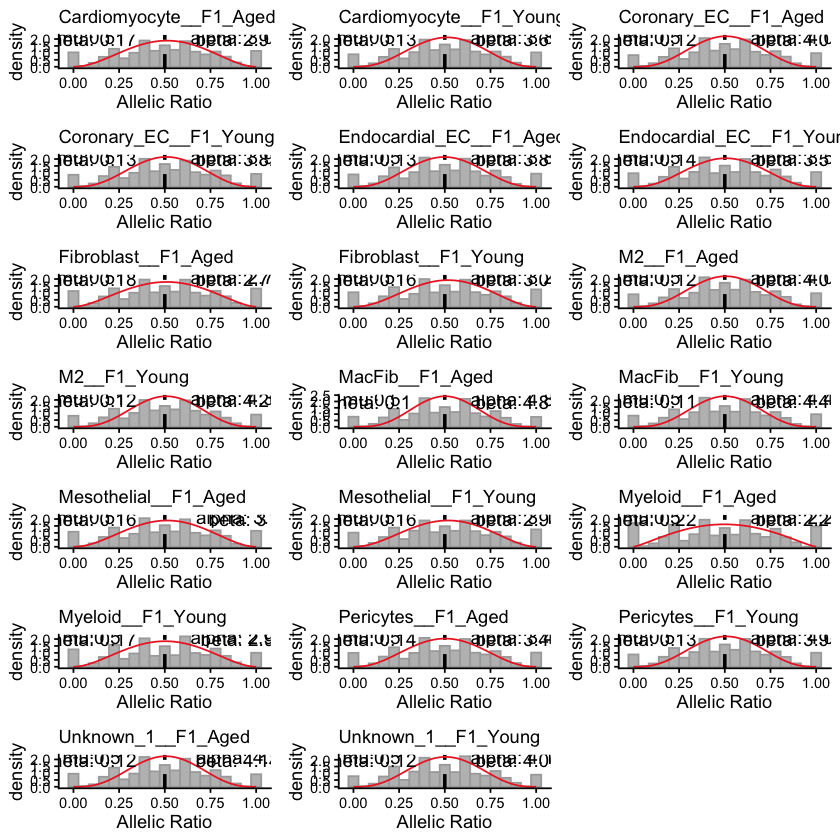

In [49]:
## assumes ASPEN functions are already available
library(gridExtra)
library(ggplot2)

sce_path <- "../data/aspensce_sexupdated_F1_filtered.rds"
glob_dir <- "../results/celltype_wo_condition"

sce  <- readRDS(sce_path)
meta <- as.data.frame(colData(sce))
ct_col <- intersect(c("celltype_new","celltype","celltype_old"), names(meta))[1]
stopifnot(!is.na(ct_col))

sex_all <- meta$sex
sex_all <- as.character(sex_all)
sex_all[sex_all %in% c("Female","F")] <- "F"
sex_all[sex_all %in% c("Male","M")]   <- "M"
cond_all <- meta$condition_new
if (is.null(cond_all)) cond_all <- meta$condition_old
cond_all <- as.character(cond_all)
cond_all[is.na(cond_all) | cond_all == ""] <- "NA"

load_gparams <- function(group_path) {
  f <- file.path(group_path, "global_params.csv")
  if (!file.exists(f)) return(NULL)
  df <- read.csv(f, row.names = 1, check.names = FALSE)
  vals <- df[1, c("mu","theta","alpha","beta")]
  as.numeric(vals)
}

plots <- list()
for (i in seq_len(nrow(group_info))) {
  grp_path <- group_info$path[i]
  grp_id   <- group_info$group_id[i]
  gparams <- load_gparams(grp_path)
  if (is.null(gparams) || any(!is.finite(gparams))) {
    message("No global_params.csv for ", grp_id, "; skipping.")
    next
  }

  cols <- which(meta[[ct_col]] == group_info$celltype[i] &
                 cond_all == group_info$condition[i] &
                 sex_all %in% c("F","M"))
  if (length(cols) < 5) {
    message("Too few cells for ", grp_id, "; skipping.")
    next
  }

  a1  <- as.matrix(assays(sce)[["a1"]][, cols, drop = FALSE]); mode(a1)  <- "integer"
  tot <- as.matrix(assays(sce)[["tot"]][, cols, drop = FALSE]); mode(tot) <- "integer"

  p <- plot_glob_params(a1, tot, gparams, min_counts = 5) +
       ggplot2::labs(subtitle = grp_id)
  plots[[grp_id]] <- p
}

if (length(plots)) {
  gridExtra::grid.arrange(grobs = plots, ncol = 3)
} else {
  message("No panels to display (nothing matched).")
}


## normalised test results

In [50]:
use_norm <- TRUE  # FALSE = raw-input test, TRUE = normalized-input test

sce  <- readRDS("../data/aspensce_sexupdated_F1_filtered.rds")
meta <- as.data.frame(colData(sce))
ct_col <- intersect(c("celltype_new","celltype","celltype_old"), names(meta))[1]

sex_all <- as.character(meta$sex)
sex_all[sex_all %in% c("Female","F")] <- "F"
sex_all[sex_all %in% c("Male","M")]   <- "M"
cond_all <- meta$condition_new
if (is.null(cond_all)) cond_all <- meta$condition_old
cond_all <- as.character(cond_all)
cond_all[is.na(cond_all) | cond_all == ""] <- "NA"

cells_keep <- which(sex_all %in% c("F","M"))

min_counts <- 5
min_cells  <- 10

for (i in seq_len(nrow(group_info))) {
  ct <- group_info$celltype[i]
  cond_label <- group_info$condition[i]
  grp_path <- group_info$path[i]

  cols <- which(meta[[ct_col]] == ct & cond_all == cond_label & sex_all %in% c("F","M"))
  if (length(cols) < min_cells) {
    message("No estimates for ", group_info$group_id[i], " (too few cells)")
    next
  }

  est_path <- file.path(grp_path, "estimates_global_shrunk.rds")
  if (!file.exists(est_path)) { message("No estimates for ", group_info$group_id[i]); next }
  est_shrunk <- readRDS(est_path)

  a1_raw  <- as.matrix(assays(sce)[["a1"]][, cols, drop = FALSE]);  mode(a1_raw)  <- "integer"
  tot_raw <- as.matrix(assays(sce)[["tot"]][, cols, drop = FALSE]); mode(tot_raw) <- "integer"

  common <- intersect(rownames(est_shrunk), rownames(tot_raw))
  if (!length(common)) next
  est_ct  <- est_shrunk[common, , drop = FALSE]
  a1_ct   <- a1_raw[common, , drop = FALSE]
  tot_ct  <- tot_raw[common, , drop = FALSE]

  if (use_norm) {
    sf <- Matrix::colSums(tot_ct)
    sf <- sf / exp(mean(log(sf)))
    tot_ct <- sweep(tot_ct, 2, sf, "/")
    a1_ct  <- sweep(a1_ct,  2, sf, "/")
  }

  gp_path <- file.path(grp_path, "global_params.csv")
  if (!file.exists(gp_path)) { message("No global params for ", group_info$group_id[i]); next }
  gp_df <- read.csv(gp_path, row.names = 1, check.names = FALSE)
  gp <- as.numeric(gp_df[1, c("mu","theta","alpha","beta")])
  names(gp) <- c("mu","theta","alpha","beta")

  res_bb <- bb_mean(a1_counts = a1_ct,
                    tot_counts = tot_ct,
                    estimates  = est_ct,
                    glob_params = gp,
                    min_cells = min_cells,
                    min_counts = min_counts)

  suffix <- if (use_norm) "norm" else "rawrep"
  write.csv(as.data.frame(res_bb), file.path(grp_path, sprintf("bb_mean_results_%s.csv", suffix)), row.names = TRUE)
  saveRDS(res_bb, file.path(grp_path, sprintf("bb_mean_results_%s.rds", suffix)))
}


## heat map for the top genes with the mean deviation from balance

In [52]:
## (1) Heatmap: genes with FDR < 0.05 in at least one group (bb_mu)
if (!"ComplexHeatmap" %in% loadedNamespaces()) library(ComplexHeatmap)
if (!"circlize" %in% loadedNamespaces())      library(circlize)

res_list <- Filter(Negate(is.null), results_fdr)
if (length(res_list) == 0) {
    message("No result data frames available."); return(invisible(NULL))
}

group_map <- setNames(group_info$path, group_info$group_id)

df_list <- lapply(res_list, function(df) {
    if (is.null(df$gene)) df$gene <- rownames(df)
    if (!"group_id" %in% colnames(df)) {
        df$group_id <- paste(df$celltype, df$condition, sep = "__")
    }
    keep <- intersect(c("gene","group_id","p.adj","bb_mu","celltype","condition"), colnames(df))
    df[, keep, drop = FALSE]
})

combined_results <- do.call(rbind, df_list)

req_cols <- c("gene", "group_id", "p.adj", "bb_mu")
miss <- setdiff(req_cols, colnames(combined_results))
if (length(miss)) stop("Missing expected columns: ", paste(miss, collapse = ", "))

sig_mask <- is.finite(combined_results$p.adj) & combined_results$p.adj < 0.05
sig_genes <- unique(combined_results$gene[sig_mask])
if (!length(sig_genes)) {
    message("No genes pass FDR < 0.05."); return(invisible(NULL))
}

filtered <- combined_results[combined_results$gene %in% sig_genes, , drop = FALSE]
agg <- aggregate(bb_mu ~ gene + group_id, data = filtered, FUN = mean)

genes <- sort(unique(agg$gene))
grps  <- sort(unique(agg$group_id))
heatmap_mat <- matrix(NA_real_, length(genes), length(grps),
                      dimnames = list(genes, grps))
idx <- cbind(match(agg$gene, genes), match(agg$group_id, grps))
heatmap_mat[idx] <- agg$bb_mu

keep_rows <- rowSums(is.finite(heatmap_mat)) > 0
keep_cols <- colSums(is.finite(heatmap_mat)) > 0
heatmap_mat <- heatmap_mat[keep_rows, keep_cols, drop = FALSE]

if (!nrow(heatmap_mat) || !ncol(heatmap_mat)) {
    message("No finite values remain after filtering; nothing to plot.")
    return(invisible(NULL))
}

heatmap_mat_plot <- pmin(pmax(heatmap_mat, 0), 1)
heatmap_mat_plot[is.na(heatmap_mat_plot)] <- 0.5

col_fun <- circlize::colorRamp2(c(0, 0.5, 1), c("blue", "white", "red"))
ht_all <- Heatmap(
    heatmap_mat_plot,
    name = "bb_mu",
    col = col_fun,
    na_col = "grey90",
    show_row_names = TRUE,
    show_column_names = TRUE,
    cluster_rows = TRUE,
    cluster_columns = TRUE,
    heatmap_legend_param = list(title = "bb_mu (allelic ratio)")
)

draw(ht_all)
dev.off()


agg_record_1305459565 
                    2

In [55]:
## (2) Per-group top 50 bb_mu heatmaps (ranked by p.adj)
if (!"ComplexHeatmap" %in% loadedNamespaces()) library(ComplexHeatmap)
if (!"circlize" %in% loadedNamespaces())      library(circlize)

col_bb <- circlize::colorRamp2(c(0, 0.5, 1), c("blue", "white", "red"))

for (i in seq_len(nrow(group_info))) {
    grp_id <- group_info$group_id[i]
    df <- if (!is.null(names(res_list)) && grp_id %in% names(res_list)) {
        res_list[[grp_id]]
    } else if (i <= length(res_list)) {
        res_list[[i]]
    } else {
        NULL
    }
    if (is.null(df)) next
    if (is.null(df$gene)) df$gene <- rownames(df)
    if (!all(c("gene","p.adj","bb_mu") %in% colnames(df))) next

    grp_path <- group_info$path[i]

    finite_mask <- is.finite(df$p.adj)
    num_sig <- sum(finite_mask & df$p.adj < 0.05, na.rm = TRUE)
    message(sprintf("%s: %d genes with FDR < 0.05", grp_id, num_sig))

    df_finite <- df[finite_mask, , drop = FALSE]
    if (!nrow(df_finite)) next

    df_finite <- df_finite[order(df_finite$p.adj), ]
    top_n  <- min(50, nrow(df_finite))
    df_top <- df_finite[seq_len(top_n), , drop = FALSE]

    mat <- matrix(df_top$bb_mu, ncol = 1,
                  dimnames = list(df_top$gene, "bb_mu"))
    mat[!is.finite(mat)] <- NA_real_

    ht_ct <- Heatmap(
        mat,
        name = "bb_mu",
        col  = col_bb,
        show_row_names = TRUE,
        show_column_names = FALSE,
        cluster_rows = TRUE,
        cluster_columns = FALSE,
        column_title = grp_id,
        heatmap_legend_param = list(title = "bb_mu (allelic ratio)")
    )

    message("Rendering top genes for ", grp_id)
    draw(ht_ct)

    out_pdf <- file.path(grp_path, sprintf("bb_mean_top50_%s_heatmap.pdf", grp_id))
    dir.create(dirname(out_pdf), showWarnings = FALSE, recursive = TRUE)
    pdf(out_pdf, width = 4, height = 10)
    draw(ht_ct)
    dev.off()
}


Cardiomyocyte__F1_Aged: 3062 genes with FDR < 0.05

Rendering top genes for Cardiomyocyte__F1_Aged

Cardiomyocyte__F1_Young: 635 genes with FDR < 0.05

Rendering top genes for Cardiomyocyte__F1_Young

Coronary_EC__F1_Aged: 193 genes with FDR < 0.05

Rendering top genes for Coronary_EC__F1_Aged

Coronary_EC__F1_Young: 310 genes with FDR < 0.05

Rendering top genes for Coronary_EC__F1_Young

Endocardial_EC__F1_Aged: 212 genes with FDR < 0.05

Rendering top genes for Endocardial_EC__F1_Aged



## Analysis for sex effect genes

In [64]:
## (4) GLM coefficient utilities (shared helpers)
load_glm_coef_table <- function(grp_id) {
    grp_path <- group_map[[grp_id]]
    if (is.null(grp_path))
        stop(sprintf("Unknown group_id: %s", grp_id))
    candidates <- c(
        file.path(grp_path, "glm_coef_by_gene.csv"),
        file.path("..", grp_path, "glm_coef_by_gene.csv")
    )
    idx <- which(file.exists(candidates))[1]
    if (is.na(idx)) {
        stop(sprintf("Coefficient table not found for %s (searched: %s)", grp_id, paste(candidates, collapse = ", ")))
    }
    read.csv(candidates[idx], stringsAsFactors = FALSE)
}

extract_sig_terms <- function(grp_id, pattern = "^sex", alpha = 0.05) {
    tbl <- tryCatch(load_glm_coef_table(grp_id), error = function(e) NULL)
    if (is.null(tbl) || !nrow(tbl)) {
        message("No coefficients available for ", grp_id)
        return(list(genes = character(), table = tbl[0, ]))
    }
    keep <- grepl(pattern, tbl$term) & is.finite(tbl$p)
    sub_tbl <- tbl[keep, , drop = FALSE]
    sig_tbl <- sub_tbl[sub_tbl$p < alpha, , drop = FALSE]
    sig_tbl <- sig_tbl[order(sig_tbl$p), , drop = FALSE]
    list(
        genes = unique(sig_tbl$gene),
        table = sig_tbl
    )
}

build_signed_logp_matrix <- function(grp_id, terms_regex = "^sex", top_genes = 40) {
    tbl <- tryCatch(load_glm_coef_table(grp_id), error = function(e) NULL)
    if (is.null(tbl) || !nrow(tbl)) {
        message("No coefficients available for ", grp_id)
        return(list(matrix = NULL, table = tbl[0, ]))
    }
    keep <- grepl(terms_regex, tbl$term) & is.finite(tbl$p)
    tbl <- tbl[keep, , drop = FALSE]
    if (!nrow(tbl)) {
        message("No matching coefficient terms for ", grp_id)
        return(list(matrix = NULL, table = tbl))
    }
    tbl$score <- sign(tbl$estimate) * -log10(pmax(tbl$p, .Machine$double.xmin))
    tbl <- tbl[order(tbl$p), , drop = FALSE]
    genes <- unique(tbl$gene)
    if (length(genes) > top_genes) genes <- genes[seq_len(top_genes)]
    tbl_top <- tbl[tbl$gene %in% genes, , drop = FALSE]
    terms <- sort(unique(tbl_top$term))
    mat <- matrix(NA_real_, length(genes), length(terms),
                  dimnames = list(genes, terms))
    if (nrow(tbl_top)) {
        for (i in seq_len(nrow(tbl_top))) {
            g <- tbl_top$gene[i]
            term <- tbl_top$term[i]
            mat[g, term] <- tbl_top$score[i]
        }
    }
    list(matrix = mat, table = tbl_top)
}


In [67]:
## Sex-term heatmaps of signed -log10(p)
if (!"ComplexHeatmap" %in% loadedNamespaces()) suppressPackageStartupMessages(library(ComplexHeatmap))
if (!"circlize" %in% loadedNamespaces()) suppressPackageStartupMessages(library(circlize))

plot_sex_heatmap <- function(grp_id, top_genes = 40, extra_formats = c("png","tiff"), show_plot = TRUE,
                             quantile_cap = 0.95, min_limit = 1) {
  grp_path <- group_map[[grp_id]]
  if (is.null(grp_path)) {
    message("Unknown group: ", grp_id); return(invisible(NULL))
  }
  res <- build_signed_logp_matrix(grp_id, terms_regex = "^sex", top_genes = top_genes)
  mat <- res$matrix
  if (is.null(mat) || !is.matrix(mat) || nrow(mat) == 0 || all(is.na(mat))) {
    message("Skipping ", grp_id, " (no coefficient data)."); return(invisible(NULL))
  }

  sex_cols <- grep("^sex", colnames(mat), value = TRUE)
  if (!length(sex_cols)) { message("No sex columns for ", grp_id, "."); return(invisible(NULL)) }
  mat <- mat[, sex_cols, drop = FALSE]

  finite_vals <- as.numeric(mat[is.finite(mat)])
  if (!length(finite_vals)) {
    message("All values NA for ", grp_id); return(invisible(NULL))
  }
  cap_val <- stats::quantile(abs(finite_vals), probs = quantile_cap, names = FALSE, na.rm = TRUE)
  cap_val <- max(cap_val, min_limit)
  mat_cap <- pmax(pmin(mat, cap_val), -cap_val)
  col_fun <- circlize::colorRamp2(c(-cap_val, 0, cap_val), c("blue","white","red"))

  make_ht <- function() {
    Heatmap(
      as.matrix(mat_cap),
      name = "signed_log10p",
      col = col_fun,
      na_col = "grey90",
      cluster_rows = TRUE,
      cluster_columns = FALSE,
      show_row_names = TRUE,
      show_column_names = TRUE,
      column_title = grp_id,
      heatmap_legend_param = list(title = "sign(estimate) * -log10(p)",
                                  at = round(seq(-cap_val, cap_val, length.out = 5), 2))
    )
  }

  pdf_h    <- max(4, min(12, nrow(mat_cap) * 0.25 + 2))
  pdf_path <- file.path(grp_path, sprintf("glm_coef_signed_logp_heatmap_%s_sex.pdf", grp_id))
  grDevices::pdf(pdf_path, width = 6, height = pdf_h)
  draw(make_ht(), newpage = TRUE)
  grDevices::dev.off()

  stem <- tools::file_path_sans_ext(pdf_path)
  extra_paths <- character(0)
  for (ext in extra_formats) {
    out_file <- paste0(stem, ".", tolower(ext))
    dev_fun <- switch(tolower(ext),
                      png  = grDevices::png,
                      jpeg = grDevices::jpeg,
                      jpg  = grDevices::jpeg,
                      tiff = grDevices::tiff,
                      tif  = grDevices::tiff,
                      stop("Unsupported format: ", ext))
    dev_fun(out_file, width = 6, height = pdf_h, units = "in", res = 200)
    draw(make_ht(), newpage = TRUE)
    grDevices::dev.off()
    extra_paths <- c(extra_paths, out_file)
  }

  if (isTRUE(show_plot)) draw(make_ht(), newpage = TRUE)

  invisible(list(matrix = mat_cap, pdf = pdf_path, extra = extra_paths, limit = cap_val))
}

coef_heatmap_outputs <- lapply(group_info$group_id, plot_sex_heatmap)
names(coef_heatmap_outputs) <- group_info$group_id


No coefficients available for Myeloid__F1_Young

Skipping Myeloid__F1_Young (no coefficient data).

No coefficients available for Unknown_1__F1_Young

Skipping Unknown_1__F1_Young (no coefficient data).



# Tile plot for changes in allelic ratio